In [4]:
from numpy import pi, log, sqrt 
import getdist
import numpy as np
from io import StringIO
from getdist import plots, MCSamples
import random
from scipy.integrate import quad
from scipy.integrate import odeint
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy import stats
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior
import scipy.optimize as op
from numpy.linalg import inv
from mpi4py import MPI
import sympy as sp
import scipy.linalg as la
import pandas as pd

# Cosmic Chronometers Dataset with Full Covariance

**Source:** [https://gitlab.com/mmoresco/CCcovariance](https://gitlab.com/mmoresco/CCcovariance)

### Description

This analysis utilizes the Cosmic Chronometers (CC) dataset with the full covariance matrix and prepares the likelihood function for cosmological parameter estimation.

### Citation Guidelines

If you use this dataset, please cite the following foundational works by Prof. Dr. Moresco:

- Moresco et al. (2016), [arXiv:1804.05864](https://doi.org/10.48550/arXiv.1804.05864)  
- Moresco (2020), [arXiv:2003.07362](https://doi.org/10.48550/arXiv.2003.07362)  

Additionally, when using the same data, please acknowledge these important references:

- Simon et al. (2005), [arXiv:1201.3609](https://doi.org/10.48550/arXiv.1201.3609)  
- Stern et al. (2010), [arXiv:1503.01116](https://doi.org/10.48550/arXiv.1503.01116)  
- Moresco et al. (2012), [arXiv:1601.01701](https://doi.org/10.48550/arXiv.1601.01701)  

In [5]:
#Load CC dataset and Build Full Covariance Matrix
filename = 'data/HzTable_MM_BC03.dat'
z, Hz, errHz = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(filename, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')


filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]


cov_mat = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
inv_cov_mat = inv(cov_mat)

cov_mat_cc = inv_cov_mat

# PantheonPlus Dataset (CosmoSIS Likelihood)

**Source Link:** [Pantheon+ CosmoSIS Likelihood Script](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/5_COSMOLOGY/cosmosis_likelihoods/Pantheon%2B_only_cosmosis_likelihood.py)  
**Dataset Link:** [Pantheon+ Distances and Covariance](https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR)

### Description

This analysis utilizes the full **STAT+SYS** covariance matrix provided in the PantheonPlus data release to construct a supernova likelihood. The approach follows the CosmoSIS likelihood format and incorporates both statistical and systematic uncertainties in the SN Ia light curves.

### Citation Guidelines

If you use this dataset or the associated likelihood script in your research, please cite the following key works:

- **Pantheon+ Compilation and Analysis Methodology:**
  - Brout et al. (2022), [arXiv:2112.03863](https://doi.org/10.48550/arXiv.2112.03863)
  - Scolnic et al. (2022), [arXiv:2202.04077](https://doi.org/10.48550/arXiv.2202.04077)

- **Covariance Matrix Construction:**
  - Conley et al. (2011), [arXiv:1104.1443](https://doi.org/10.48550/arXiv.1104.1443)

In [6]:
#Load Pantheonplus dataset and Build the Covariance Matrix
values_filename = 'data/Pantheon+SH0ES.dat'
cov_filename = 'data/Pantheon+SH0ES_STAT+SYS.cov'

data = pd.read_csv(values_filename, sep=r'\s+')
origlen = len(data)
ww = (data['zHD'] > 0.01)  # Filter condition for zHD > 0.01
zcmb = data['zHD'][ww].values  # vpec corrected redshift (zCMB)
zhelio = data['zHEL'][ww].values  # Heliocentric redshift
mag = data['m_b_corr'][ww].values  # Corrected magnitudes
N = len(mag)

filename = cov_filename
#print("Loading covariance from {}".format(filename))
f = open(filename)
line = f.readline()
n = int(len(zcmb))
C = np.zeros((n,n))
ii = -1
jj = -1
mine = 999
maxe = -999
for i in range(origlen):
    jj = -1
    if ww[i]:
        ii += 1
    for j in range(origlen):
        if ww[j]:
            jj += 1
        val = float(f.readline())
        if ww[i]:
            if ww[j]:
                C[ii,jj] = val

f.close()
#print('Done')
cov = C
xdiag = 1/cov.diagonal()  # diagonal before marginalising constant
cov += 3**2
zmin = zcmb.min()
zmax = zcmb.max()
zmaxi = 1.1 ## we interpolate to 1.1 beyond that exact calc
#print("Pantheon SN: zmin=%f zmax=%f N=%i" % (zmin, zmax, N))
ninterp=150
zinter = np.linspace(1e-3, zmaxi, ninterp)
icov = la.inv(cov)

# DESI DR2 Dataset with Full Covariance

**Source of Dataset:**  
[DESI BAO Data - GitHub (CobayaSampler)](https://github.com/CobayaSampler/bao_data)

### Description

This analysis utilizes incorporates the **DESI Data Release 2 (DR2)** dataset, which includes baryon acoustic oscillation (BAO) measurements derived from over 14 million galaxies and quasars. The full covariance matrix is used in the likelihood analysis to properly account for measurement uncertainties and correlations between data points.

The dataset is made publicly available and formatted for direct use in cosmological inference frameworks such as [Cobaya](https://cobaya.readthedocs.io/) and [CosmoMC](https://cosmologist.info/cosmomc/).

### Citation Guidelines

If you use this dataset in your work, please cite the following:

- **DESI Collaboration (2024)**  
  _The completed DR2 BAO analysis methodology and results_  
  [arXiv:2503.14738](https://doi.org/10.48550/arXiv.2503.14738)

In [ ]:
#loading BAO dataset with Covarinace matrix
dirBD= "data/desi_gaussian_bao_ALL_GCcomb_mean.txt"
BaoData = np.genfromtxt(dirBD)
xarr = np.array(BaoData[:,0])
yarr = np.array(BaoData[:,1])

funarr = np.genfromtxt(dirBD,dtype='str')[:,2]
print(funarr)

def modelArr(name):
    mod = []

    for j in range(len(funarr)):
        if (funarr[j] == name):
             mod.append([xarr[j],yarr[j]])
    mod = np.array(mod)
    mod = mod[np.argsort(mod[:,0])]
    return mod

cov_bao = np.loadtxt("data/desi_gaussian_bao_ALL_GCcomb_cov.txt")  
cov_bao_inv = np.linalg.inv(cov_bao)

['DVrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd' 'DHrd' 'DMrd'
 'DHrd' 'DHrd' 'DMrd']


1. **Define the normalized Hubble function** $E(\theta, z)$:

$$
E(z) = \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)}
$$

2. **The Hubble function** $H(\theta, z)$:

$$
H(z) = H_0 \times E(z)
$$


In [ ]:
#H functions
c = 299792.458

def E(theta,z):
    H0, Om, rd, M = theta
    OL = 1 - Om
    return np.sqrt(Om*(1+z)**3 + OL)

def H(theta,z):
    H0, Om, rd, M = theta
    arr = []
    for j in range(len(z)):
        arr.append(H0*E(theta,z[j]))
    arr = np.array(arr)
    return arr

H([67,0.32,147,-19],[1,2,3])

array([120.6      , 204.5421228, 308.2      ])

3. The comoving distance function $D_H(\theta, z)$:

$$
D_H(z) = \frac{c}{H(z)}
$$

4. The comoving distance scaled by the sound horizon:

$$
\frac{D_H(z)}{r_d} = \frac{c}{H(z) \times r_d}
$$


In [ ]:
#DH functions
def DH(theta,z):
    H0, Om, rd, M = theta
    arr = []
    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])))
    arr = np.array(arr)
    return arr

def DHrd(theta,z):
    H0, Om, rd, M = theta
    arr = []

    for j in range(len(z)):
        arr.append(c/(H0*E(theta,z[j])*rd))
    arr = np.array(arr)
    return arr

DHrd([67,0.32,147,-19],[1,2,3])

array([16.91048488,  9.97058429,  6.61714626])

The Sk function $S_k(\theta, x)$:

$$
S_k(x) = 
\begin{cases} 
\frac{\sin\left(\sqrt{-\Omega_k} \, x\right)}{\sqrt{-\Omega_k}} & \text{if } \Omega_k < -10^{-15} \\
\frac{\sinh\left(\sqrt{\Omega_k} \, x\right)}{\sqrt{\Omega_k}} & \text{if } \Omega_k > 10^{-15} \\
x & \text{if } \Omega_k = 0
\end{cases}
$$

Where:

* $\Omega_k$ is the curvature parameter (based on the `Ok` variable in your function).
* $x$ is the input variable in the function.

This function evaluates different cases based on the sign and magnitude of $\Omega_k$ (denoted as `Ok`), using either the sine or hyperbolic sine functions, or returning $x$ when $\Omega_k = 0$.


In [ ]:
def Sk(theta,x):
    H0, Om, rd, M = theta
    Ok =0
    if Ok < -10**(-15):
        return np.sin(np.sqrt(-Ok)*x)/np.sqrt(-Ok)
    #if Ok == 0:
    #    return x
    elif Ok > 10**(-15):
        return np.sinh(np.sqrt(Ok)*x)/np.sqrt(Ok)
    else:
        return x

**Derivative of $\chi$ with respect to $z$** :

$$
\frac{d\chi}{dz} = \frac{1}{E(\theta, z)}
$$

**Integral of $\chi$** :

$$
\chi(z) = \int_0^z \frac{dz'}{E(\theta, z')}
$$


In [ ]:
# function that returns dDC/dz,df/dz
def dchidz(x,z, H0, Om, rd, M):
    return 1/E([H0, Om, rd, M],z)

def chiInt(theta,z):
    H0, Om, rd, M = theta
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Om, rd, M,))
    return np.delete(arr ,0)

chiInt([67,0.32,147,-19],[1,2,3])

array([0.7624812 , 1.18936468, 1.45585048])

5. The comoving distance function $D_H(\theta, z)$:

$$
D_H(z) = \frac{c}{H(z)}
$$

6. The comoving distance scaled by the sound horizon:

$$
\frac{D_H(z)}{r_d} = \frac{c}{H(z) \times r_d}
$$


In [ ]:
#DM

def DM(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/H0)
    arr = np.array(arr)
    arr.shape
    return arr

def DMrd(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)

    arr = []

    for i in range(len(z)):
        arr.append(c*Sk(theta,chi[i])/(H0*rd))
    arr = np.array(arr)
    arr.shape
    return arr

DMrd([67,0.32,147,-19],[1,2,3])

array([23.20906838, 36.20292027, 44.31444763])

7. The comoving distance function $D_H(\theta, z)$:

$$
D_H(z) = \frac{c}{H(z)}
$$

8. The comoving distance scaled by the sound horizon:

$$
\frac{D_H(z)}{r_d} = \frac{c}{H(z) \times r_d}
$$


In [ ]:
#DV

def DV(theta,z):
    H0, Om, rd, M = theta
    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2))
    arr = np.array(arr)
    arr.shape
    return arr

def DVrd(theta,z):

    H0, Om, rd, M = theta

    dh = DH(theta,z)
    dm = DM(theta,z)
    arr = []

    for i in range(len(z)):
        arr.append(np.cbrt(z[i]*dh[i]*dm[i]**2)/rd)
    arr = np.array(arr)
    arr.shape
    return arr

DVrd([67,0.32,147,-19],[0.295,0.510,2.330])

array([ 8.09489205, 12.88345356, 31.38816821])

In [ ]:
def DL(theta,z):
    H0, Om, rd, M = theta
    chi = chiInt(theta,z)
    return c*chi/H0

def mu(theta,z):
    H0, Om, rd, M = theta
    dL = DL(theta,z)
    mu = []

    for i in range(len(z)):
        mu.append(5*np.log10(dL[i]*(1+z[i])) + 25 + M)
    mu = np.array(mu)
    mu.shape
    return mu

In [ ]:
def Omega_Lambda(theta):
    H0, Om, rd, M = theta
    OL = 1 - Om
    return OL

In [ ]:
def lnlike(theta,model,z,Hz,cov_mat_cc):
    prediction = model(theta,z)
    residualcc = prediction - Hz
    chi2 = residualcc.T @ cov_mat_cc @ residualcc
    return chi2

def lnlikeCC(theta):
    chi = 0; i = 0
    chi += lnlike(theta, H, z, Hz, cov_mat_cc)
    i += len(z)
    OL = Omega_Lambda(theta)
    return -chi, [i, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeCC([67,0.32,147,-19]))

(np.float64(-6.183367402883179), [15, np.float64(0.5621243093530163), np.float64(0.8608533971088996), 0.6799999999999999])


In [ ]:
# likelihood with covariance matrix
def lnlikecov(theta, model, x, y, cov):
    prediction = []

    for i in range(len(model)):
        fun = model[i]
        prediction.append(eval(fun)(theta, [x[i]]))
    prediction = np.array(prediction)[:, 0]
    vec = (prediction - y)
    result = np.dot(np.dot(vec, cov), vec.T)
    return result

print(lnlikecov([67, 0.32, 147, -19], funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv))

40.55527665589692


In [ ]:
def lnlikeBAO(theta):
    x = np.array(BaoData[:, 0])
    y = np.array(BaoData[:, 1])

    # Use your manually loaded inverse covariance matrix
    chi = lnlikecov(theta, funarr, x, y, cov_bao_inv)
    i = len(x)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi / (i - len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i - len(theta))), OL]

lnlikeBAO([67,0.32,147,-19])

(np.float64(-40.55527665589692),
 [np.float64(40.55527665589692),
  np.float64(4.506141850655213),
  np.float64(6.0255719672719366e-06),
  0.6799999999999999])

In [ ]:
def A(theta, x, y, icov):
    Mu = mu(theta, x)
    residual = y - Mu
    chi2 = residual.T @ icov @ residual
    return chi2

def lnlikeSNIa(theta):
    chi = A(theta, zcmb, mag, icov)
    i = len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)),1-stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeSNIa([67,0.32,147,-19]))

(np.float64(-1404.0729915402674), [np.float64(1404.0729915402674), np.float64(0.8852919240480879), np.float64(0.9995970365291555), 0.6799999999999999])


In [ ]:
def lnlikeTot(theta):

    chi = lnlikecov(theta, funarr, np.array(BaoData[:, 0]), np.array(BaoData[:, 1]), cov_bao_inv)
    i = len(BaoData[:, 0])
    chi += lnlike(theta, H, z, Hz, cov_mat_cc); i += len(z)
    chi += A(theta, zcmb, mag, icov);i += len(zcmb)
    OL = Omega_Lambda(theta)
    return -chi, [chi, chi/(i-len(theta)), 1 - stats.chi2.cdf(x=chi, df=(i-len(theta))),OL]

print(lnlikeTot([67,0.32,147,-19]))

(np.float64(-1450.8116355990473), [np.float64(1450.8116355990473), np.float64(0.8988919675334865), np.float64(0.9984785063048669), 0.6799999999999999])


In [ ]:
runs = 100

In [ ]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [ ]:
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(UniformPrior(100.,200.)(hypercube[2]))
    prior.append(GaussianPrior(-19.00,0.57)(hypercube[3]))
    return prior

In [ ]:
settingsTot = PolyChordSettings(4,4)
settingsTot.file_root = 'CC + SNIa + BAO'
settingsTot.nlive = runs
settingsTot.do_clustering = True
settingsTot.read_resume = False

In [ ]:
outputTot = pypolychord.run_polychord(lnlikeTot, 4,4, settingsTot, uniprior, dumper)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       4
nDerived :       4
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/CC + SNIa + BAO.resume

generating live points


all live points generated

Speed  1 =  0.319E-02 seconds
number of repeats:           20
started sampling

Last dead point: [ 6.18766278e+01  8.68427955e-01  1.55274003e+02 -1.94982751e+01
  8.25861423e+03  5.11686136e+00  0.00000000e+00  1.31572045e-01
 -3.17515689e+04 -8.25861423e+03]
_________________
lives      | 100 |
phantoms   |1237 |
posteriors | 101 |
equals     |   1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =             

In [ ]:
paramnames = [('H0','H_{0}'),('Om', r'\Omega_{m0}'),('rd','r_d (Mpc)'),('M',r'\mathcal{M}'),('L',r'L'),('Ldof',r'L/Dof'),('p','p'),('Omega_Lambda', r'\Omega_{\Lambda0}')]
outputTot.make_paramnames_files(paramnames)

posteriorTot = outputTot.posterior

chains/CC + SNIa + BAO.txt
Removed no burn in


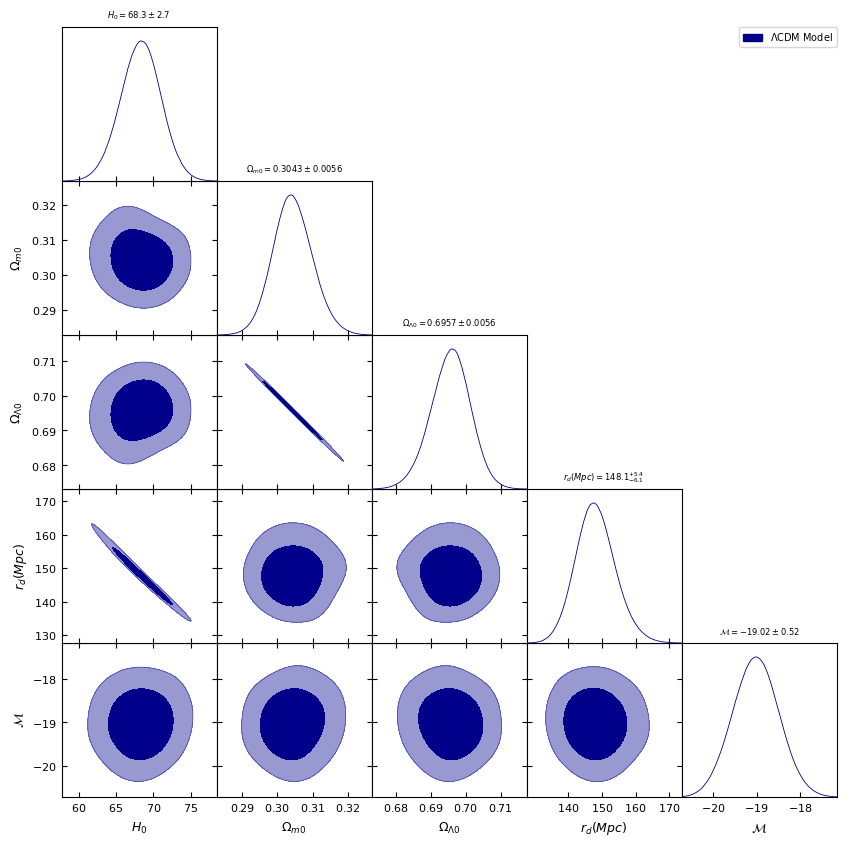

In [ ]:
g = getdist.plots.getSubplotPlotter(width_inch=10.0)
g.settings.figure_legend_frame = True  # Remove frame around the legend
g.settings.alpha_filled_add = 0.6  # Adjust transparency of filled contours
g.settings.title_limit_fontsize = 9 # Limit title fontsize to 14
g.settings.axes_labelsize = 12  # Adjust label fontsize
g.settings.legend_fontsize = 10  # Adjust legend fontsize
g.settings.colorbar_axes_fontsize = 10  # Adjust colorbar fontsize
g.triangle_plot([posteriorTot], ('H0','Om','Omega_Lambda','rd', 'M') ,filled=True, contour_colors=['darkblue'], legend_loc='upper right', legend_labels=[r'$\Lambda$CDM Model'],title_limit=1)
g.export("fig_1.pdf")

In [ ]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        #print("\nupper limit 95 C.L. = %f" % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        #print("lower limit 95 C.L. = %f" % lower)
        print("%s = %f +/- %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.16),\
        mean - samples.confidence(i, limfrac=0.025)) )
    return
for i in ["Tot"]:
    print(i)
    get_constraints(eval("posterior"+i))

Tot
H_{0} = 68.319860 +/- 2.554248 +/- 5.595545
\Omega_{m0} = 0.304349 +/- 0.005319 +/- 0.010277
r_d (Mpc) = 148.071701 +/- 5.412974 +/- 11.142750
\mathcal{M} = -19.023304 +/- 0.521333 +/- 1.047191
L = 1424.475745 +/- 1.026893 +/- 1.331156
L/Dof = 0.882575 +/- 0.000636 +/- 0.000825
p = 0.999733 +/- 0.000019 +/- 0.000070
\Omega_{\Lambda0} = 0.695651 +/- 0.005704 +/- 0.012196
